Importing librares

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn import preprocessing
from bioinfokit.visuz import cluster
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from collections import Counter
from statsmodels.graphics.mosaicplot import mosaic


In [2]:

def read_dataset(file_path):
    df = pd.read_csv(file_path)
    return df



In [3]:
def perform_eda(df, figuresize=(20, 30)):
    cat_cols = []
    con_cols = []

    plt.figure(figsize=figuresize)
    u = int((df.shape[1] + 1) / 2)
    x = 1

    for col in df.columns:
        if df[col].dtypes == "object":
            cat_cols.append(col)
            plt.subplot(u, 2, x)
            x += 1
            sns.countplot(df[col])
        else:
            con_cols.append(col)
            plt.subplot(u, 2, x)
            x += 1
            sns.distplot(df[col])

    plt.tight_layout()
    plt.show()
    print(df.corr())


In [4]:
def plot_gender_pie(df):
    labels = ['Female', 'Male']
    sizes = df['Gender'].value_counts()
    colors = ['pink', 'crimson']
    explode = [0, 0.1]
    plt.rcParams['figure.figsize'] = (7, 7)
    plt.pie(sizes, colors=colors, explode=explode, labels=labels, shadow=True, autopct='%.2f%%')
    plt.title('Gender', fontsize=20)
    plt.axis('off')
    plt.legend()
    plt.show()

In [5]:
def plot_age_distribution(df):
    plt.rcParams['figure.figsize'] = (25, 8)
    data = sns.countplot(x=df['Age'], palette='viridis')
    data.bar_label(data.containers[0])
    plt.title('Age distribution of customers', fontsize=20)
    plt.show()

In [6]:
def plot_likeliness(df):
    df['Like'] = df['Like'].replace({'I hate it!-5': '-5', 'I love it!+5': '+5'})
    sns.catplot(data=df, x="Like", y="Age", orient="v", height=5, aspect=2, palette="Set2", kind="swarm")
    plt.title('Likelihood of McDonalds w.r.t Age', fontsize=20)
    plt.show()

In [7]:
def label_encode_binary_features(df):
    df_new = df.drop(labels=['Like', 'Age', 'VisitFrequency', 'Gender'], axis=1)
    df_encoded = df_new.apply(LabelEncoder().fit_transform)
    return df_encoded

In [10]:
def apply_pca(df_encoded):
    pca_data = preprocessing.scale(df_encoded)
    pca = PCA(n_components=11)
    pc = pca.fit_transform(pca_data)
    names = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11']
    pf = pd.DataFrame(data=pc, columns=names)

    # Variance (from PC1 to PC11)
    print("Explained variance ratio:", pca.explained_variance_ratio_)

    # Correlation coefficient between original variables and the component
    loadings = pca.components_
    num_pc = pca.n_features_
    pc_list = ["PC" + str(i) for i in list(range(1, num_pc + 1))]
    loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
    loadings_df['feature'] = df_encoded.columns.values
    loadings_df = loadings_df.set_index('feature')

    # Correlation matrix plot for loadings
    plt.rcParams['figure.figsize'] = (20, 15)
    ax = sns.heatmap(loadings_df, annot=True, cmap='Purples')
    plt.show()

    return pf

In [11]:
def perform_kmeans_clustering(df_encoded):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, 12)).fit(df_encoded)
    visualizer.show()

    kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(df_encoded)
    df['cluster_num'] = kmeans.labels_

    print('Labels:', kmeans.labels_)
    print('WCSS:', kmeans.inertia_)
    print('No. of iterations:', kmeans.n_iter_)
    print('Cluster centroids:', kmeans.cluster_centers_)
    print('Cluster size:', Counter(kmeans.labels_))

    sns.scatterplot(data=pf, x="pc1", y="pc2", hue=kmeans.labels_)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker="X", c="r", s=80,
                label="centroids")
    plt.legend()
    plt.show()

    crosstab = pd.crosstab(df['cluster_num'], df['Like'])
    crosstab = crosstab[['-5', '-4', '-3', '-2', '-1', '0', '+1', '+2', '+3', '+4', '+5']]

    plt.rcParams['figure.figsize'] = (7, 7)
    mosaic(crosstab.stack())
    display(crosstab, plt.show())

    crosstab_gender = pd.crosstab(df['cluster_num'], df['Gender'])

    plt.rcParams['figure.figsize'] = (7, 5)
    mosaic(crosstab_gender.stack())
    display(crosstab, plt.show())

    sns.boxplot(x="cluster_num", y="Age", data=df)

    visit = df.groupby('cluster_num')['VisitFrequency'].mean()
    visit = visit.to_frame().reset_index()

    Like = df.groupby('cluster_num')['Like'].mean()
    Like = Like.to_frame().reset_index()

    Gender = df.groupby('cluster_num')['Gender'].mean()
    Gender = Gender.to_frame().reset_index()

    segment = Gender.merge(Like, on='cluster_num', how='left').merge(visit, on='cluster_num', how='left')

    plt.figure(figsize=(9, 4))
    sns.scatterplot(x="VisitFrequency", y="Like", data=segment, s=400, color="r")
    plt.title("Simple segment evaluation plot for the fast food data set", fontsize=15)
    plt.xlabel("Visit", fontsize=12)
    plt.ylabel("Like", fontsize=12)
    plt.show()


In [12]:
file_path = "mcdonalds_dataset.csv"
df = read_dataset(file_path)


C:\Users\ritik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ritik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ritik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ritik\anaconda3\lib\si

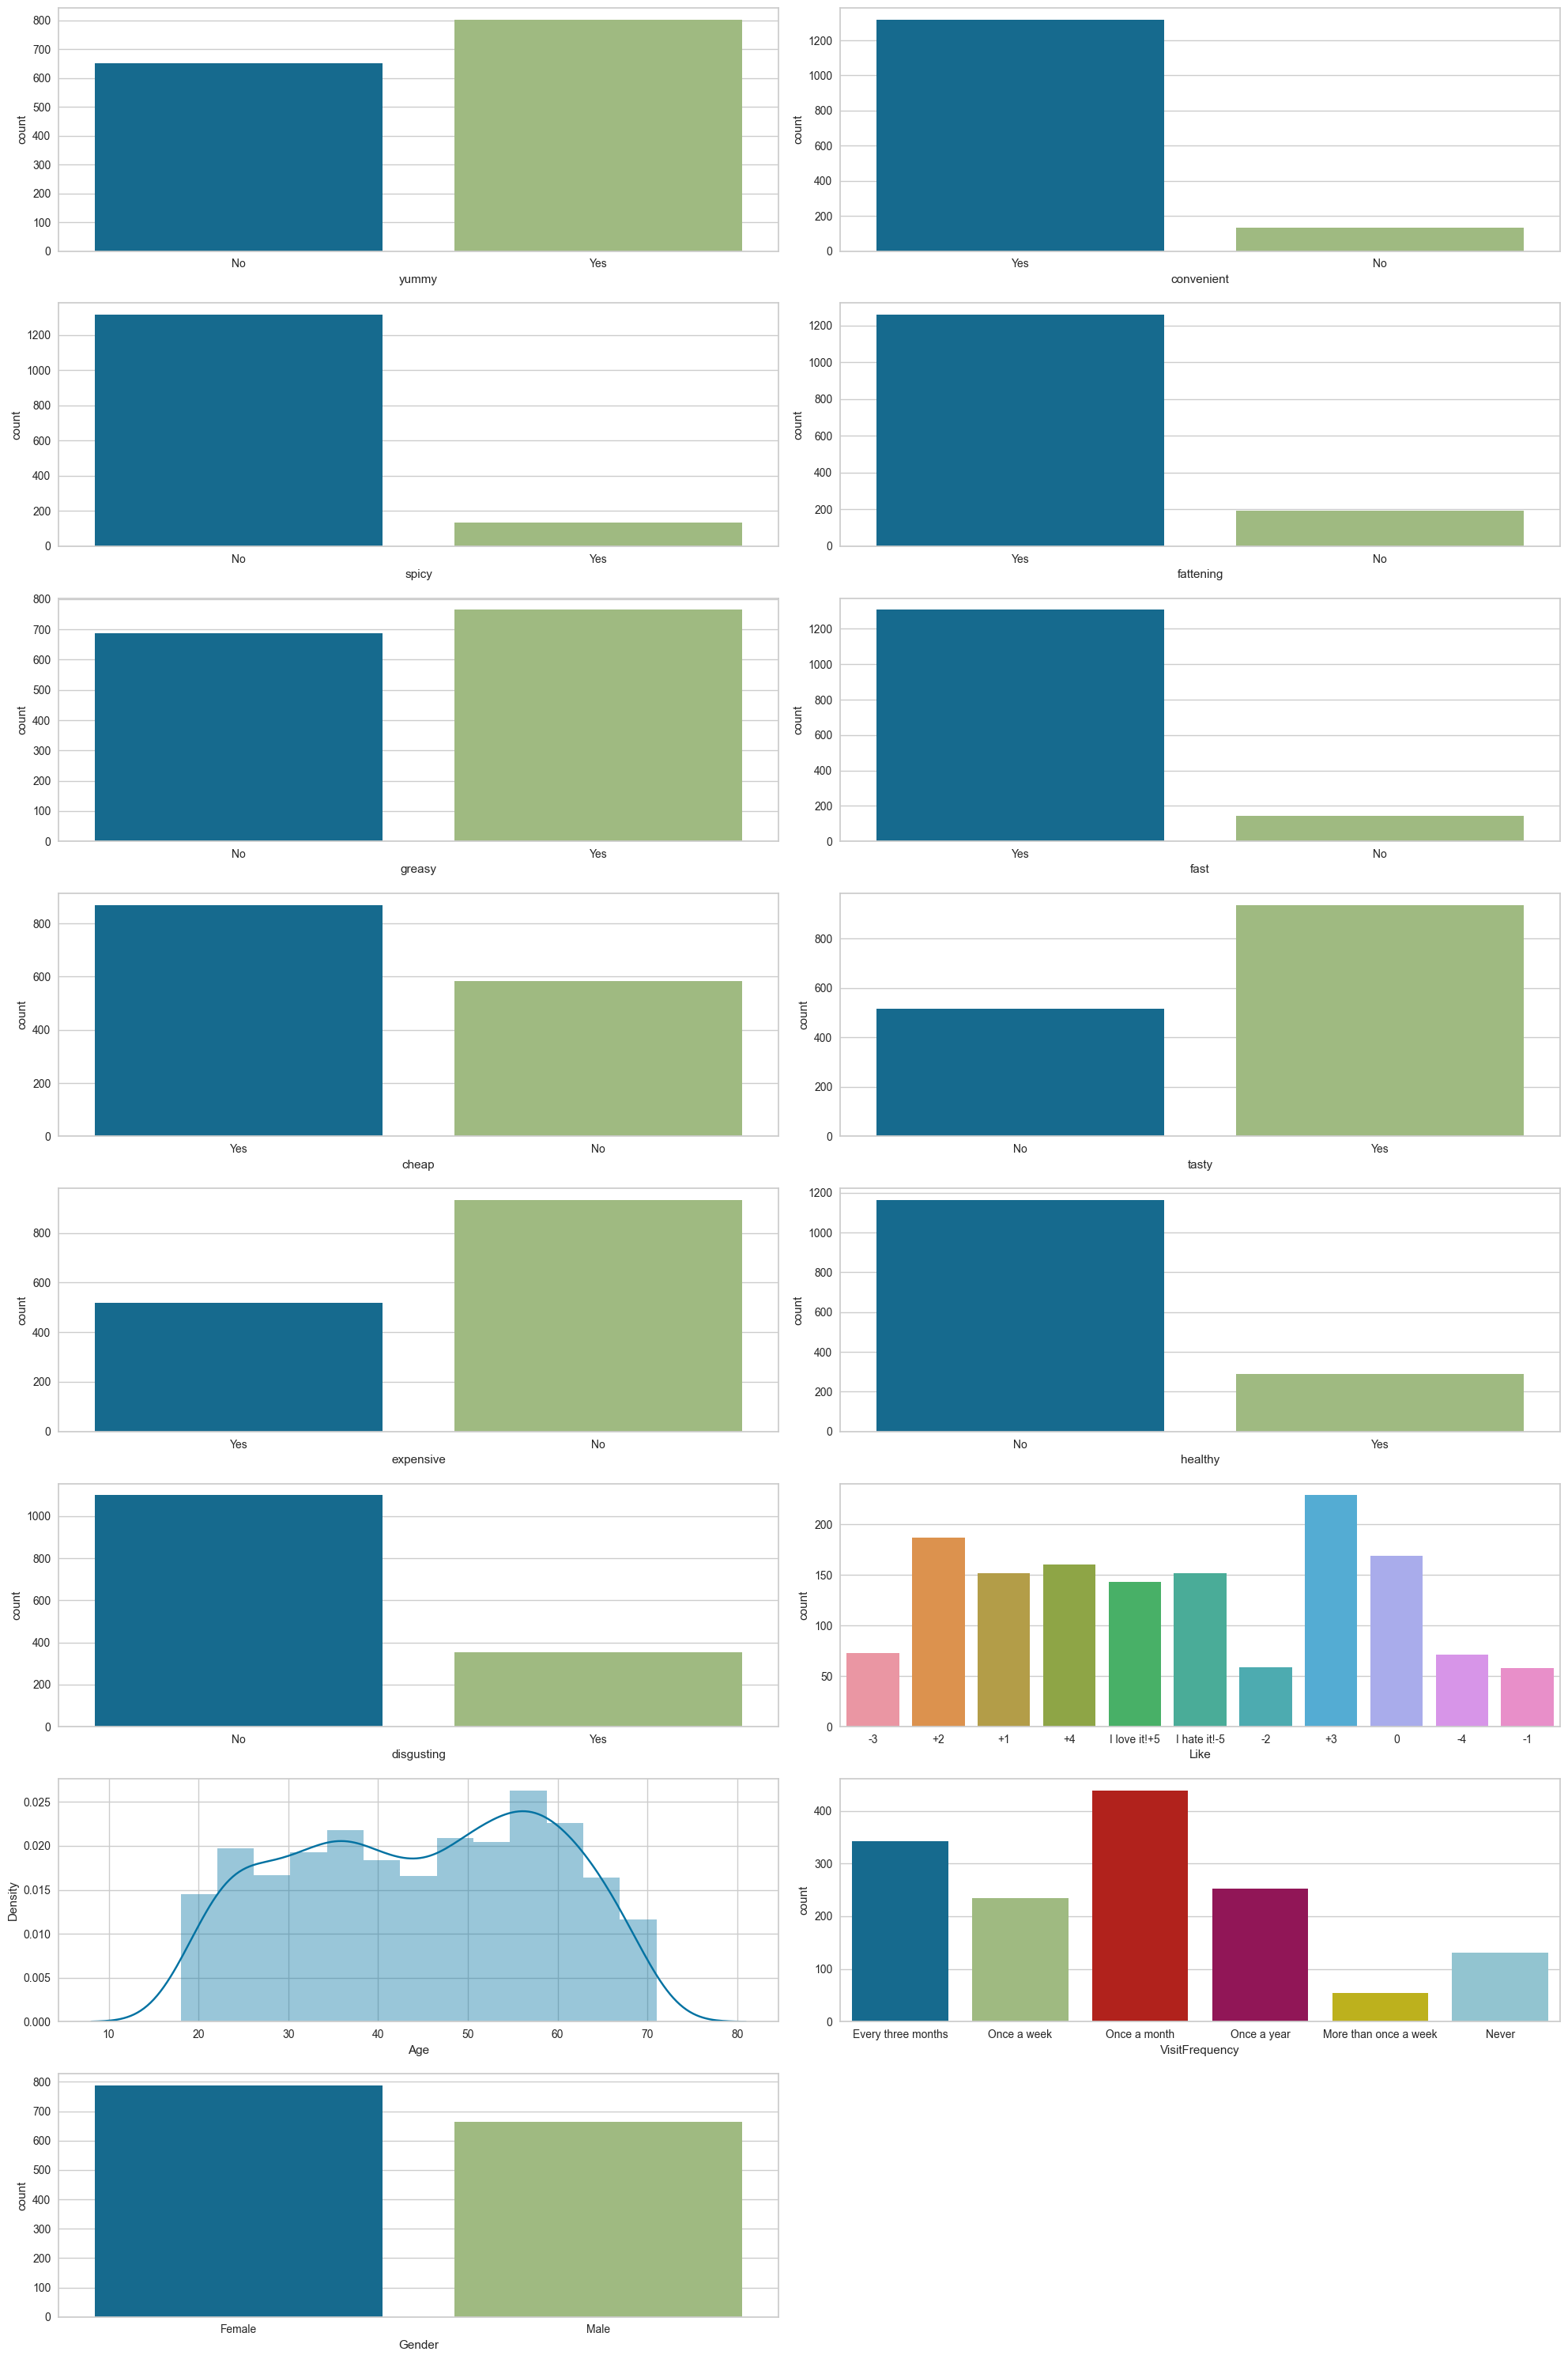

     Age
Age  1.0


In [13]:
perform_eda(df, figuresize=(20, 30))


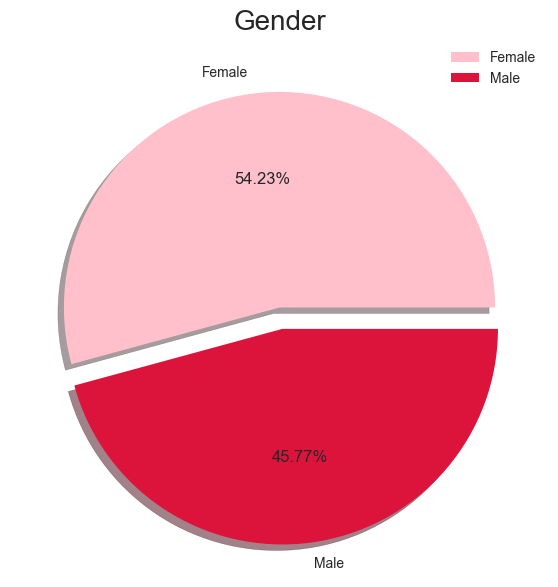

In [14]:
plot_gender_pie(df)


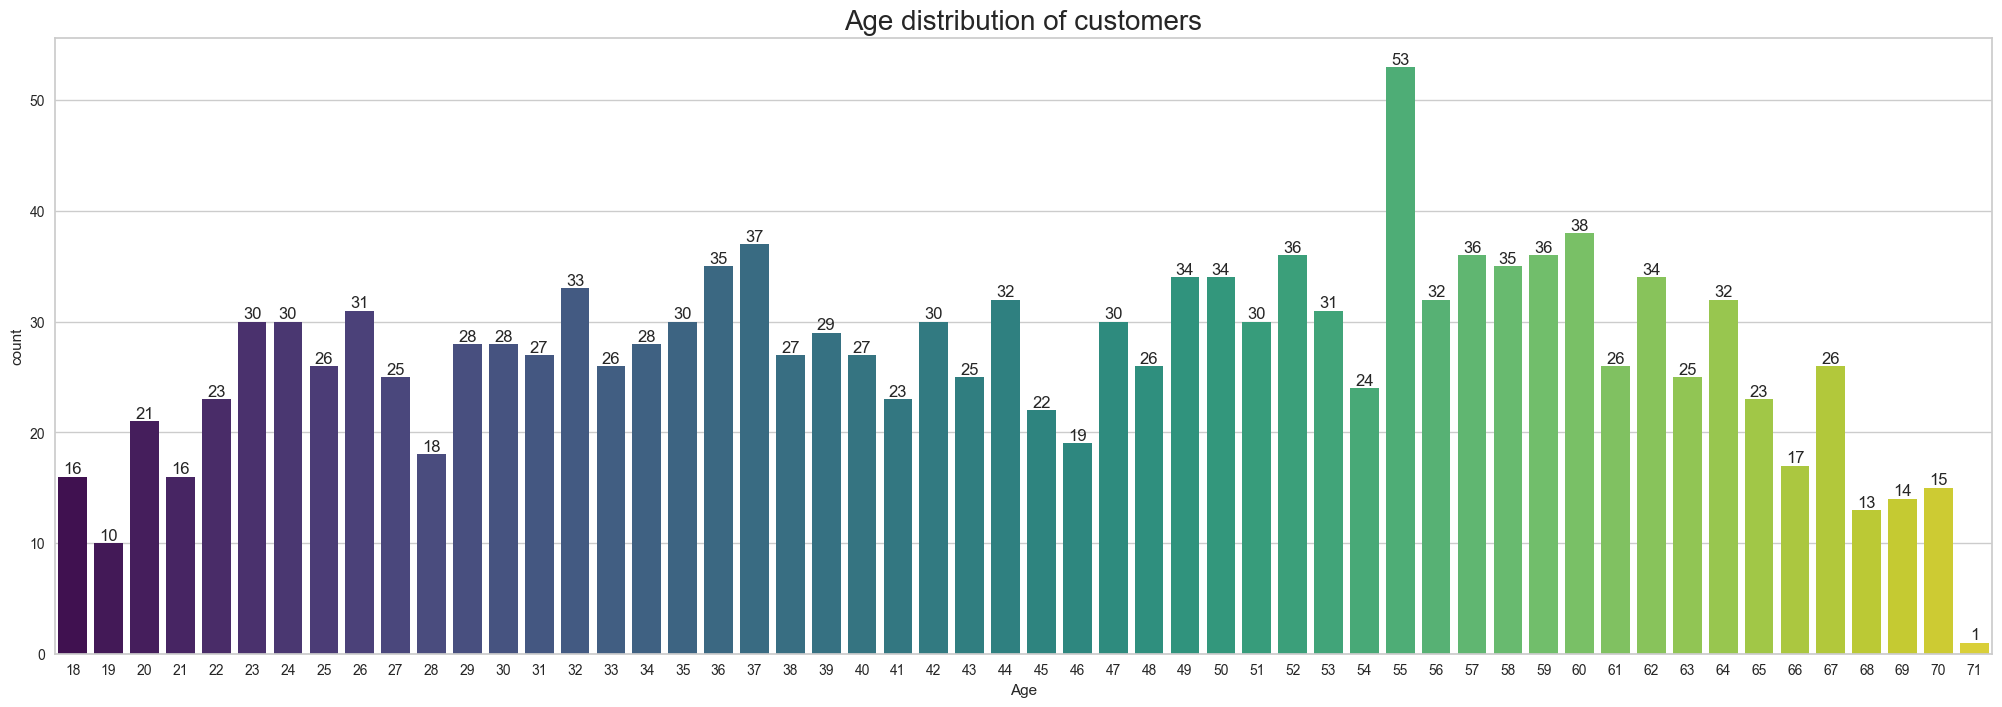

In [15]:
plot_age_distribution(df)


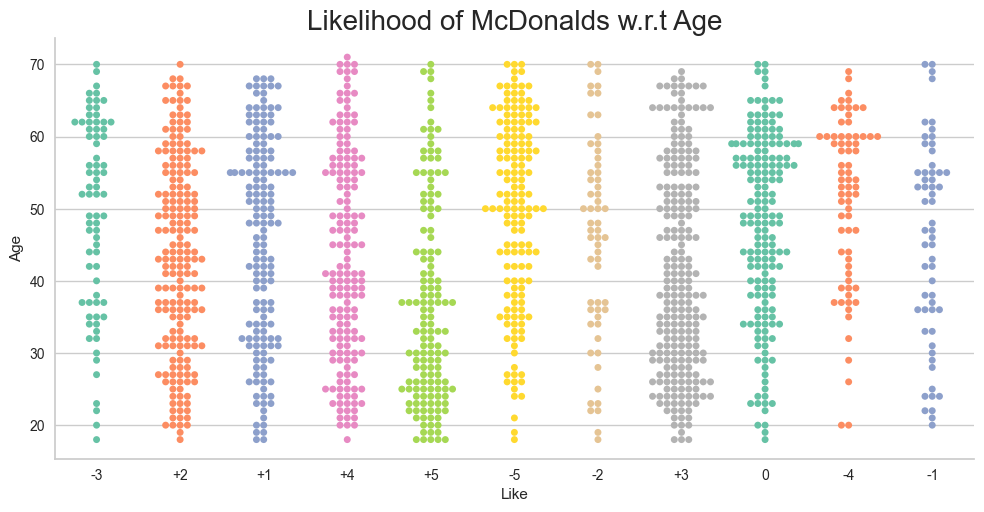

In [16]:
plot_likeliness(df)


In [17]:
df_encoded = label_encode_binary_features(df)


Explained variance ratio: [0.25556637 0.14834762 0.12546909 0.09826971 0.08348356 0.07109102
 0.06498559 0.05384477 0.04762809 0.02796379 0.0233504 ]


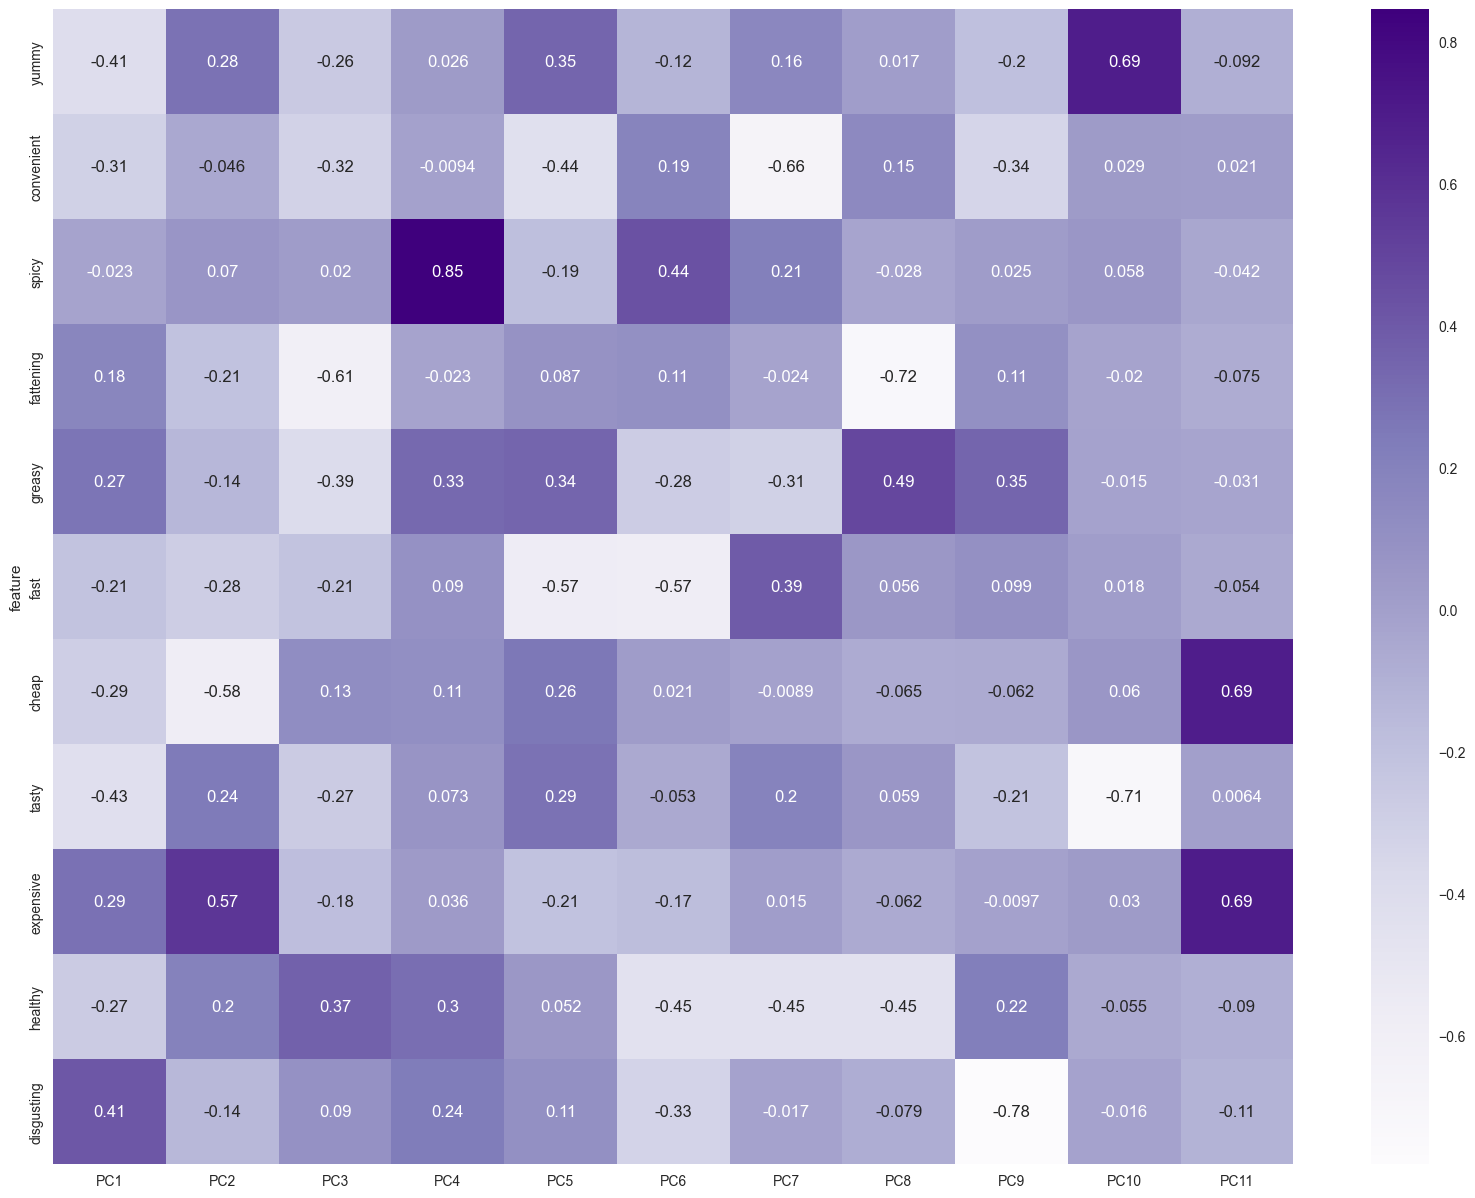

In [18]:
pf = apply_pca(df_encoded)


C:\Users\ritik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


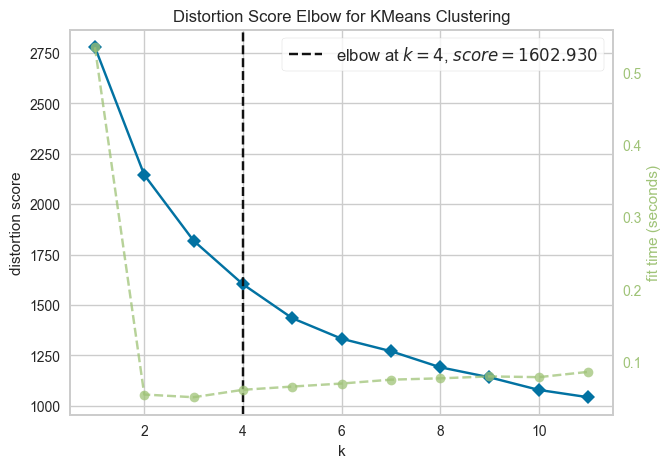

Labels: [2 0 0 ... 0 1 3]
WCSS: 1603.0604440558916
No. of iterations: 7
Cluster centroids: [[0.85448916 0.9628483  0.13312693 0.90712074 0.61919505 0.86068111
  0.10835913 0.93188854 0.89783282 0.20433437 0.10526316]
 [0.88793103 0.98103448 0.0862069  0.79482759 0.32931034 0.96034483
  0.92241379 0.97586207 0.01724138 0.32068966 0.04310345]
 [0.02302632 0.89144737 0.07236842 0.92434211 0.66776316 0.96381579
  0.93421053 0.15460526 0.01315789 0.07236842 0.38815789]
 [0.0203252  0.68292683 0.08536585 0.91463415 0.69512195 0.73170732
  0.06504065 0.08943089 0.87804878 0.06097561 0.71544715]]
Cluster size: Counter({1: 580, 0: 323, 2: 304, 3: 246})


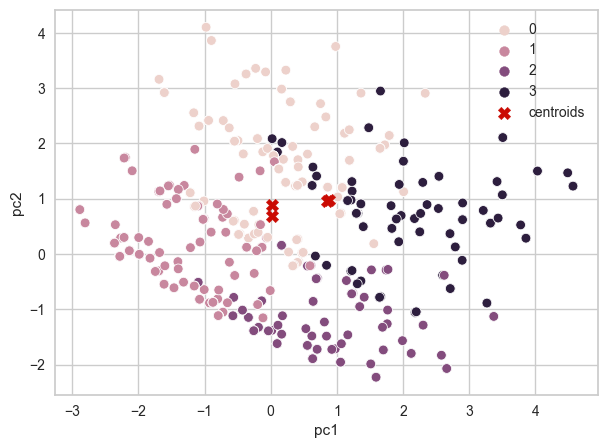

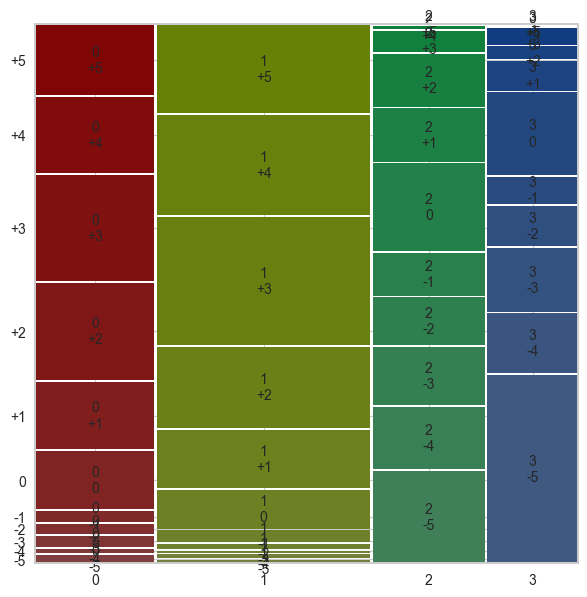

Like,-5,-4,-3,-2,-1,0,+1,+2,+3,+4,+5
cluster_num,,,,,,,,,,,
0,5,3,7,6,7,36,42,60,66,47,44
1,4,4,2,6,13,43,65,90,143,111,99
2,54,36,34,28,25,51,31,31,12,2,0
3,89,28,30,19,13,39,14,6,8,0,0


None

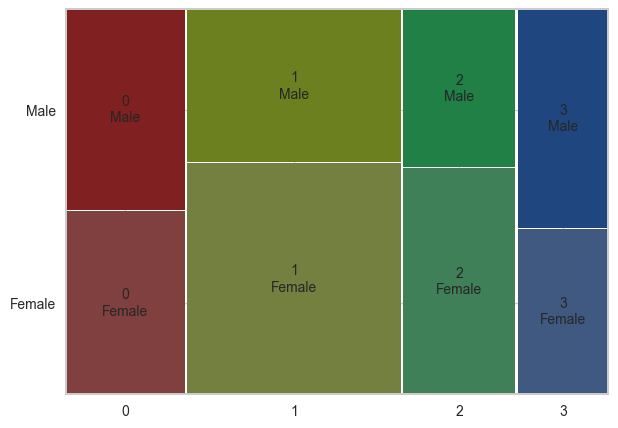

Like,-5,-4,-3,-2,-1,0,+1,+2,+3,+4,+5
cluster_num,,,,,,,,,,,
0,5,3,7,6,7,36,42,60,66,47,44
1,4,4,2,6,13,43,65,90,143,111,99
2,54,36,34,28,25,51,31,31,12,2,0
3,89,28,30,19,13,39,14,6,8,0,0


None

TypeError: Could not convert Every three monthsEvery three monthsEvery three monthsEvery three monthsOnce a monthOnce a monthOnce a monthMore than once a weekOnce a yearOnce a weekMore than once a weekEvery three monthsOnce a monthOnce a yearOnce a monthOnce a monthOnce a yearOnce a weekOnce a weekEvery three monthsOnce a yearOnce a yearOnce a monthOnce a weekEvery three monthsEvery three monthsOnce a monthOnce a yearMore than once a weekEvery three monthsOnce a weekOnce a monthOnce a monthOnce a monthEvery three monthsOnce a weekOnce a monthOnce a monthOnce a monthOnce a monthOnce a yearOnce a monthOnce a weekOnce a monthMore than once a weekNeverOnce a monthEvery three monthsOnce a monthOnce a yearEvery three monthsOnce a yearOnce a monthMore than once a weekEvery three monthsOnce a weekOnce a weekOnce a monthOnce a monthOnce a monthOnce a yearOnce a weekOnce a monthMore than once a weekOnce a monthOnce a monthOnce a monthEvery three monthsOnce a monthOnce a monthOnce a weekOnce a yearEvery three monthsEvery three monthsOnce a monthOnce a monthOnce a weekOnce a monthOnce a monthOnce a monthOnce a monthOnce a weekOnce a weekEvery three monthsOnce a weekOnce a weekEvery three monthsOnce a monthOnce a monthOnce a monthOnce a weekOnce a weekOnce a monthOnce a weekOnce a weekEvery three monthsOnce a weekOnce a yearOnce a monthEvery three monthsEvery three monthsOnce a monthOnce a monthOnce a monthOnce a monthEvery three monthsEvery three monthsEvery three monthsOnce a monthOnce a monthMore than once a weekOnce a monthOnce a monthEvery three monthsEvery three monthsOnce a monthEvery three monthsOnce a monthOnce a monthOnce a monthOnce a weekOnce a monthNeverEvery three monthsOnce a monthOnce a weekEvery three monthsMore than once a weekOnce a monthOnce a monthOnce a weekEvery three monthsOnce a weekEvery three monthsOnce a monthOnce a yearOnce a yearOnce a monthOnce a monthOnce a weekMore than once a weekOnce a weekEvery three monthsEvery three monthsEvery three monthsOnce a yearEvery three monthsOnce a weekOnce a yearOnce a monthOnce a weekOnce a monthOnce a yearOnce a monthOnce a monthOnce a yearOnce a monthOnce a monthEvery three monthsOnce a monthEvery three monthsNeverEvery three monthsOnce a monthEvery three monthsOnce a weekEvery three monthsOnce a yearMore than once a weekOnce a monthOnce a monthOnce a monthEvery three monthsOnce a yearOnce a monthOnce a monthOnce a yearEvery three monthsOnce a monthOnce a monthMore than once a weekEvery three monthsOnce a monthEvery three monthsOnce a monthOnce a yearOnce a monthOnce a monthOnce a weekOnce a weekOnce a weekOnce a weekEvery three monthsOnce a monthOnce a yearEvery three monthsEvery three monthsMore than once a weekEvery three monthsEvery three monthsEvery three monthsOnce a weekOnce a weekOnce a weekOnce a weekOnce a monthOnce a monthMore than once a weekOnce a monthOnce a monthEvery three monthsEvery three monthsOnce a monthOnce a yearOnce a monthOnce a weekOnce a monthEvery three monthsOnce a weekOnce a monthOnce a weekOnce a yearEvery three monthsOnce a monthNeverEvery three monthsOnce a weekOnce a weekEvery three monthsMore than once a weekMore than once a weekOnce a weekEvery three monthsOnce a monthOnce a yearOnce a monthOnce a monthOnce a monthOnce a weekOnce a monthEvery three monthsOnce a yearOnce a monthEvery three monthsOnce a yearMore than once a weekOnce a monthOnce a weekOnce a weekOnce a monthOnce a weekOnce a weekOnce a weekOnce a monthOnce a monthOnce a monthOnce a weekEvery three monthsEvery three monthsEvery three monthsEvery three monthsOnce a weekOnce a monthEvery three monthsOnce a weekOnce a yearOnce a monthOnce a weekEvery three monthsEvery three monthsEvery three monthsOnce a monthOnce a monthOnce a weekEvery three monthsEvery three monthsOnce a yearOnce a weekOnce a monthOnce a monthOnce a yearOnce a yearEvery three monthsOnce a monthOnce a weekMore than once a weekEvery three monthsOnce a weekOnce a monthOnce a monthOnce a monthOnce a weekOnce a monthOnce a monthEvery three monthsMore than once a weekOnce a weekOnce a weekEvery three monthsEvery three monthsMore than once a weekOnce a monthOnce a weekOnce a monthOnce a monthOnce a monthOnce a weekOnce a monthOnce a monthEvery three monthsOnce a weekEvery three monthsMore than once a weekEvery three monthsOnce a yearOnce a weekOnce a monthEvery three monthsOnce a monthOnce a monthOnce a weekOnce a monthOnce a month to numeric

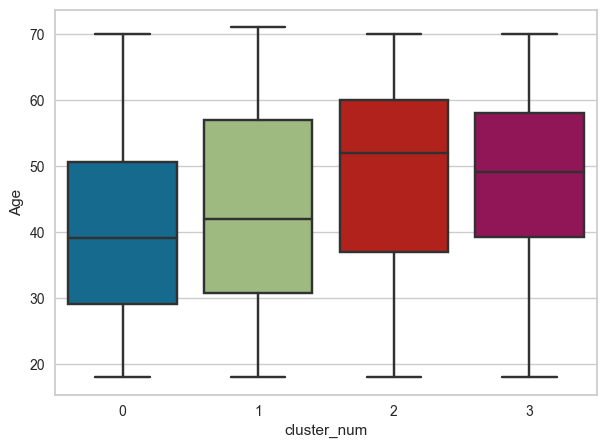

In [20]:
perform_kmeans_clustering(df_encoded)
